                                   project 2
Predicting players rating
In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.
The dataset you are going to use is from European Soccer Database
(https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than
10,000 players for European professional soccer seasons from 2008 to 2016.


In [1]:
import sqlite3
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib notebook
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel

Read Data from the Database into pandas

In [2]:
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
#dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)

In [3]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
target = df.pop('overall_rating')

In [5]:
df.shape

(183978, 41)

In [6]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

Imputing target funtion :

In [7]:
target.isnull().values.sum()

836

In [8]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

<IPython.core.display.Javascript object>


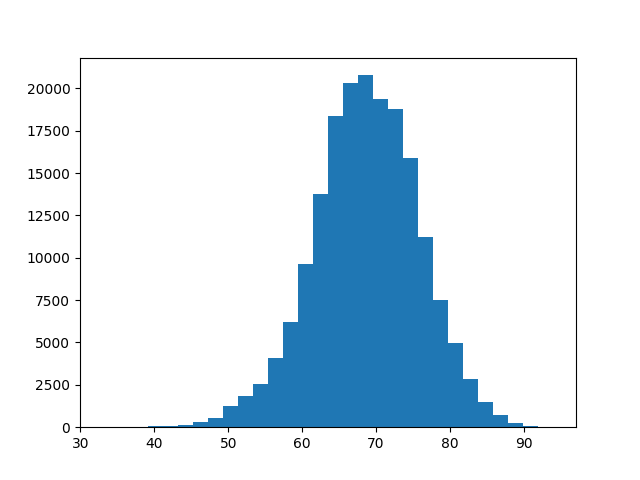

/Users/swetha/anaconda2/envs/python35/lib/python3.5/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/swetha/anaconda2/envs/python35/lib/python3.5/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([7.0000e+00, 6.0000e+00, 2.0000e+01, 6.5000e+01, 9.4000e+01,
        1.4200e+02, 2.9400e+02, 5.2600e+02, 1.2510e+03, 1.8450e+03,
        2.5780e+03, 4.0870e+03, 6.1890e+03, 9.6500e+03, 1.3745e+04,
        1.8366e+04, 2.0310e+04, 2.0773e+04, 1.9382e+04, 1.8784e+04,
        1.5915e+04, 1.1254e+04, 7.5250e+03, 4.9470e+03, 2.8290e+03,
        1.4590e+03, 7.4800e+02, 2.2800e+02, 8.4000e+01, 3.9000e+01]),
 array([33.        , 35.03333333, 37.06666667, 39.1       , 41.13333333,
        43.16666667, 45.2       , 47.23333333, 49.26666667, 51.3       ,
        53.33333333, 55.36666667, 57.4       , 59.43333333, 61.46666667,
        63.5       , 65.53333333, 67.56666667, 69.6       , 71.63333333,
        73.66666667, 75.7       , 77.73333333, 79.76666667, 81.8       ,
        83.83333333, 85.86666667, 87.9       , 89.93333333, 91.96666667,
        94.        ]),
 <a list of 30 Patch objects>)

In [9]:
plt.hist(target, 30, range=(33, 94))

In [11]:
y = target.fillna(target.mean())

In [12]:
y.isnull().values.any()

False

Data Exploration :

In [13]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [14]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))


id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

In [15]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
X = dummy_df.drop(['id', 'date'], axis=1)


Feature selection

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
#imputing null value of each column with the mean of that column
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [19]:
#finding feature_importance for feature selection. from it we'll be able to decide threshold value
model = XGBRegressor()
model.fit(X_train, y_train)
print(model.feature_importances_)
print (len(model.feature_importances_))

[0.01714286 0.02       0.10714286 0.02       0.04714286 0.03571429
 0.03285714 0.         0.04       0.         0.         0.00714286
 0.04714286 0.01       0.01571429 0.00142857 0.18571429 0.
 0.01428571 0.00571429 0.00857143 0.03142857 0.00571429 0.00714286
 0.01857143 0.01857143 0.00571429 0.         0.04285714 0.04571429
 0.01       0.04571429 0.02571429 0.02428572 0.06       0.04285714
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
65


In [20]:
selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [21]:
select_X_train.shape

(137983, 24)

Training Models

1.Decision Tree

In [22]:
model = DecisionTreeRegressor()

In [23]:
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [24]:
# Predict the target by providing the inputs to the trained model
predicted_op = model.predict(X_train)
#actual_op = target['overall_rating']

print ('predicted overall rating for 10th input:', predicted_op[10])
print ('actual overall rating for 10th input:', target[10])

print ('predicted overall rating for 20th input:', predicted_op[20])
print ('actual overall rating for 20th input:', target[20])

# check the accuracy of the model
print ('\n\nModle score is: ', model.score(X_test, y_test))



predicted overall rating for 10th input: 70.0
actual overall rating for 10th input: 73.0
predicted overall rating for 20th input: 61.0
actual overall rating for 20th input: 70.0


Modle score is:  0.960246008665681


In [27]:
predicted = model.predict(X_test)
print(predicted)

[74. 67. 70. ... 65. 73. 56.]


In [28]:
# Check training accuracy
print('Training Accuracy is: '+str(100*model.score(X_train,y_train)))

# Check testing accuracy
print('Test Accuracy is: '+str(100*model.score(X_test,y_test)))

Training Accuracy is: 99.94180413843972
Test Accuracy is: 96.0246008665681


2.linear Regressor

In [29]:
model1 = LinearRegression()

In [30]:
model1.fit(X_train, y_train)

/Users/swetha/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
# Predict the target by providing the inputs to the trained model
predicted_op = model1.predict(X_train)
#actual_op = target['overall_rating']

print ('predicted overall rating for 10th input:', predicted_op[15])
print ('actual overall rating for 10th input:', target[15])

print ('predicted overall rating for 20th input:', predicted_op[20])
print ('actual overall rating for 20th input:', target[20])

# check the accuracy of the model
print ('\n\nModle score is: ', model1.score(X_test, y_test))

predicted overall rating for 10th input: 73.96103714265442
actual overall rating for 10th input: 71.0
predicted overall rating for 20th input: 65.9124178660923
actual overall rating for 20th input: 70.0


Modle score is:  0.8582791614795209


In [32]:
predicted = model1.predict(X_test)
print(predicted)

[70.86951529 64.60362242 68.86524026 ... 65.79339082 71.99587746
 56.71308113]


In [83]:
# Check training accuracy
print('Training Accuracy is: '+str(100*model1.score(X_train,y_train)))

# Check testing accuracy
print('Test Accuracy is: '+str(100*model1.score(X_test,y_test)))

Training Accuracy is: 86.07373906644736
Test Accuracy is: 85.8279161479521
